# Neural Network Final Model - Gosan, South Korea

In [1]:
import pandas as pd
import numpy as np
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import sys
sys.path.append('../../')
import config as cfg
import functions as f

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = cfg.site
site_name = cfg.site_dict[site]
assert site == 'GSN', 'This script is only for Gosan, South Korea. The site can be changed in the config file.'

compound = cfg.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Gosan, South Korea.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
475,2008-02-11 17:00:00,1.0,3.606809,4.282457,11.727278,0.849762,3.280616,3.568215,1.175426,-0.312269,...,-6.902031,3.163988,5.541533,6.421309,-0.695788,2.676286,3.550085,-3.139078,-1.965247,-9.458879
6660,2013-07-22 23:00:00,1.0,2.880458,-1.280703,-4.003438,2.024843,1.802525,2.315362,1.254257,2.770628,...,4.765497,2.912685,4.536651,1.337879,-6.736178,-2.388087,0.988676,4.395952,3.009309,6.913268
190,2007-12-13 21:00:00,1.0,5.229158,2.331286,-1.849780,3.310393,7.166003,2.164175,-0.133740,4.398534,...,-8.555866,-8.198358,-10.755581,15.955865,9.346881,5.154085,5.267788,1.999921,-4.463654,-5.824809
5624,2012-08-02 21:00:00,1.0,-7.651175,-3.314996,-3.625885,-3.236557,-9.990013,-7.897016,-7.187233,-7.298197,...,-11.087224,5.148296,10.708876,-0.198164,0.731869,-4.645647,18.132790,-5.059176,-2.592710,2.086872
1222,2008-11-22 19:00:00,1.0,-1.839847,0.963796,8.650950,0.714783,-1.852007,-2.284476,0.529213,-3.862087,...,6.064653,-10.145239,-13.550945,-7.399214,-4.065040,-10.324068,9.663760,2.215184,1.121013,-15.349837


In [4]:
train_data = data[(data['time'].dt.year >= 2013) & (data['time'].dt.year <= 2013)]
val_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2014)]
test_data = data[(data['time'].dt.year >= 2015) & (data['time'].dt.year <= 2017)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2013-01-01 13:00:00 -> 2013-12-30 11:00:00. Length: 1066
Val range: 2014-01-02 09:00:00 -> 2014-12-31 23:00:00. Length: 915
Test range: 2015-01-01 01:00:00 -> 2017-12-31 23:00:00. Length: 2808


### Model

In [5]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.0001, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=False,
                         learning_rate_init=0.01,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

class_probabilities_val = nn_model.predict_proba(X_val)
class_probabilities_train = nn_model.predict_proba(X_train)

confidence_threshold = config.confidence_threshold

y_pred_val = (class_probabilities_val[:,1] > confidence_threshold).astype(int)
y_pred_train = (class_probabilities_train[:,1] > confidence_threshold).astype(int)

precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.885
Precision on Validation Set = 0.866
Recall on Training Set = 0.762
Recall on Validation Set = 0.814
F1 Score on Training Set = 0.819
F1 Score on Validation Set = 0.839


In [6]:
# evaluating model on test set
class_probabilities_test = nn_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:,1] > confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.886
Recall on Testing Set = 0.820
F1 Score on Testing Set = 0.852


In [13]:
# saving the model
dump(nn_model, data_path/f'nn_model_GSN.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_GSN.joblib']

### Assessing Feature Importance

In [7]:
# grouping features by category i.e. x-wind, y-wind, temporal etc.
u_features = [col for col in data.columns if 'u' in col]
v_features = [col for col in data.columns if 'v' in col]
temporal_features = ['day_of_year', 'time_of_day']
sp = ['sp']
blh = ['blh']

groups = [u_features, v_features, temporal_features, sp, blh]

In [8]:
original_score = accuracy_score(y_train, nn_model.predict(X_train))
importances = {}

for group in groups:
    scores_diff = []
    for _ in range(100):
        X_train_permuted = f.permute_group(X_train, group)
        
        permuted_score = accuracy_score(y_train, nn_model.predict(X_train_permuted))
        scores_diff.append(original_score - permuted_score)
    
    importances[str(group)] = np.mean(scores_diff)

# Sort groups by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=False)

In [9]:
# matching the group names to the sorted importances
n = len(groups)
group_names_sorted = []

for i in range(n):
    name = sorted_importances[i][0]

    if 'u10_0' in name:
        group_names_sorted.append('u-wind')

    elif 'v10_0' in name:
        group_names_sorted.append('v-wind')

    elif 'day_of_year' in name:
        group_names_sorted.append('temporal')

    elif 'sp' in name:
        group_names_sorted.append('sp')

    elif 'blh' in name:
        group_names_sorted.append('blh')

Text(0, 0.5, 'Feature Group')

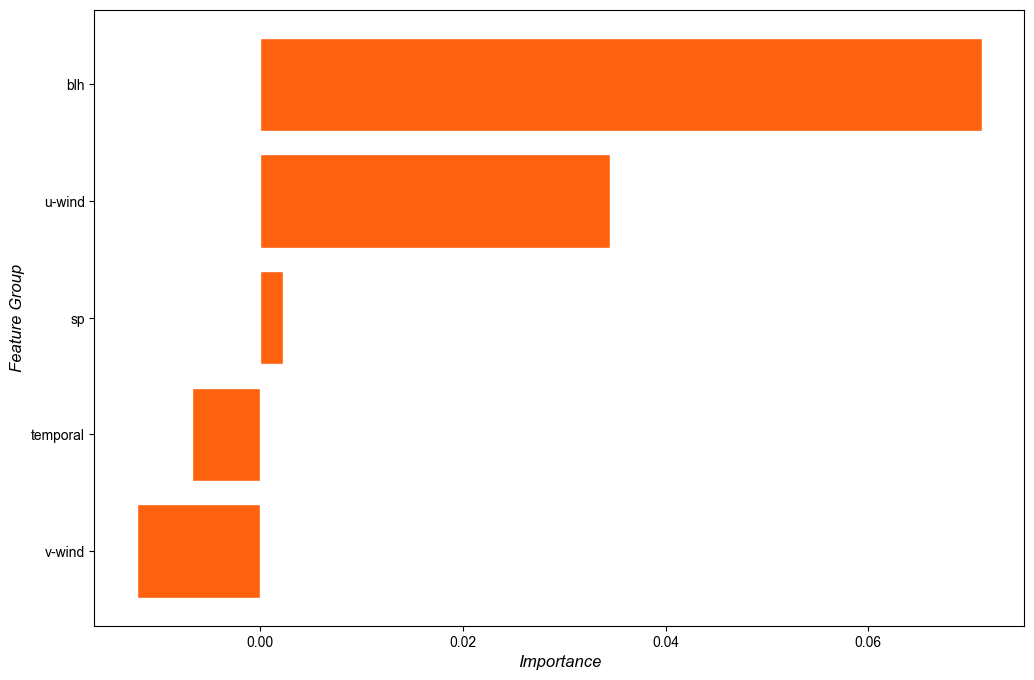

In [10]:
# Plotting the importances of the groups
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_theme(style='ticks', font='Arial')

ax.barh(group_names_sorted, [importance for _, importance in sorted_importances], color='#FF620E')

ax.set_xlabel('Importance', fontsize=12, fontstyle='italic')
ax.set_ylabel('Feature Group', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importances', fontsize=14)